In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

comment = "Synthetic core with tapered ensemble as prior"
nb_name = "nb_case_core_synthetic"
shc_g = 30
shc_grid = 30

# Load core object
file_pickle = open("{}.obj".format(nb_name), 'rb')
core = pickle.load(file_pickle)
file_pickle.close()
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = False)
core.generate_map()

# Synthetic sat
C_e_const = 2.0
s_sat = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)
s_sat.load_swarm("A")
grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)
s_sat.generate_map(grid_type = "swarm")
s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

# Source truth
s_source = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)
s_source.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.r_cmb, grid_in, calc_sph_d = False)
s_source.generate_map()

In [2]:
core.cov_model_taper(r_at = core.r_cmb, tap_to = 500, tap_exp_p1 = 5, tap_exp_p2 = 2,
                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = False)
core.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = core.C_ens_tap)
core.covmod_lsq_equiv(s_sat.data, core.C_ens_tap, core.G, core.r_cmb)

All eigenvalues > 0: True
Cov model is pos def: True


In [3]:
m_DSS_truth_res = s_source.data.reshape(-1,1)-core.m_DSS

In [4]:
np.mean(np.sqrt(np.mean(np.power(m_DSS_truth_res,2),axis=0)))*10**(-6)

0.36786096002373764

In [6]:
(0.368-0.359)/0.368*100

2.4456521739130457

In [4]:
# Source truth
s_source = SDSS(comment, N_SH = 30, sim_type = "core", sat_height = 350, N_SH_secondary = None)
s_source.grid_glq(nmax = 400, r_at = core.r_cmb)
grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.r_cmb, grid_in, calc_sph_d = False)
s_source.generate_map()

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


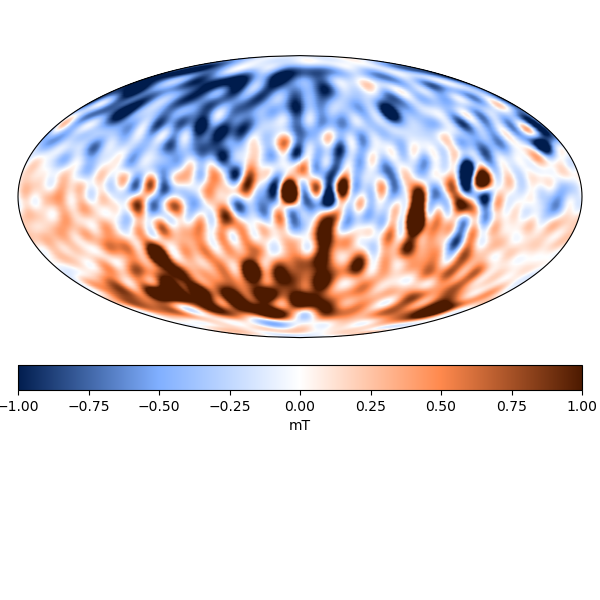

In [4]:
limit_data = [-1,1]

mt_util.plot_global(lat = 90-s_source.grid_theta, lon = s_source.grid_phi, data=s_source.data, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.0,
                bottom=0.35, top=0.95, hspace=0.01,
                title='', point_size=1,
                savefig = False, save_dpi = 100, save_string ="map_dynamo_sim_poster", save_ftype="png",
                use_gridlines = False, gridlines_width = 0.4, gridlines_alpha = 0.4)

<IPython.core.display.Javascript object>


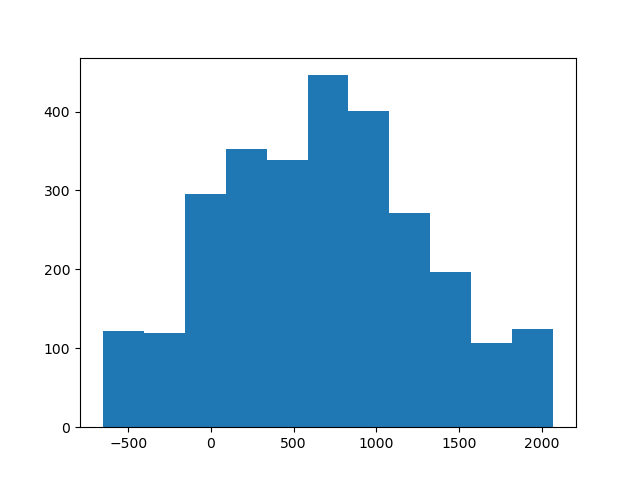

In [4]:
# MODE FROM M
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
m_DSS_hist = []
m_DSS_hist_y = []
for i in np.arange(0,core.m_DSS.shape[0]):
    y,binEdges=np.histogram(core.m_DSS[i,:],bins=21)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    m_DSS_hist.append(bincenters)
    m_DSS_hist_y.append(y)
    
m_DSS_hist = np.array(m_DSS_hist).T
m_DSS_hist_y = np.array(m_DSS_hist_y).T

idx_max_y = np.argmax(m_DSS_hist_y,axis=0)

m_DSS_mode = []
for i in np.arange(0,core.m_DSS.shape[0]):
    m_DSS_mode.append(m_DSS_hist[idx_max_y[i],i])
    
m_DSS_mode = np.array(m_DSS_mode)[:,None]

set_nmax = shc_grid
g_DSS_mode, _ = mt_util.sh_expand_glq(m_DSS_mode, core.grid_nmax, core.grid_w_shtools, core.grid_zero, set_nmax, geomag_r_at = core.r_cmb)        
g_DSS_mode = np.array(g_DSS_mode).T

core.g_spec_mode = g_DSS_mode

m_DSS_mode_pred = core.G@m_DSS_mode
m_DSS_mode_res = s_sat.data.reshape(-1,1) - m_DSS_mode_pred

plt.figure()
plt.hist(m_DSS_mode_res,bins=11)
plt.show()

<IPython.core.display.Javascript object>


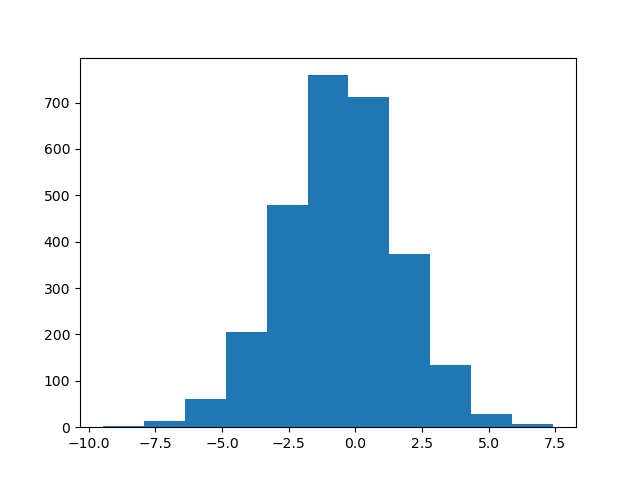

In [12]:
# MODE FROM g
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
g_hist = []
g_hist_y = []
for i in np.arange(0,core.g_spec.shape[0]):
    y,binEdges=np.histogram(core.g_spec[i,:],bins=15)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    g_hist.append(bincenters)
    g_hist_y.append(y)
    
g_hist = np.array(g_hist).T
g_hist_y = np.array(g_hist_y).T

idx_max_y = np.argmax(g_hist_y,axis=0)

g_mode = []
for i in np.arange(0,core.g_spec.shape[0]):
    g_mode.append(g_hist[idx_max_y[i],i])
    
g_mode = np.array(g_mode)

core.g_spec_mode = g_mode

core.ensemble_B(core.g_spec_mode, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
m_DSS_mode = core.B_ensemble[:,[0]].copy()

m_DSS_mode_pred = core.G@m_DSS_mode
m_DSS_mode_res = s_sat.data.reshape(-1,1) - m_DSS_mode_pred

plt.figure()
plt.hist(m_DSS_mode_res,bins=11)
plt.show()

# Results display

In [6]:
core.grid_glq(nmax = 30, r_at = core.r_cmb)

g_mean, _ = mt_util.sh_expand_glq(np.mean(core.m_DSS,axis=1), core.grid_nmax, core.grid_w_shtools, core.grid_zero, set_nmax, geomag_r_at = core.r_cmb)        
core.g_spec_mean = np.array(g_mean).T.reshape(-1,)

core.ensemble_B(core.g_spec, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
zs_DSS = core.B_ensemble[:,0].copy()
core.m_DSS = zs_DSS.copy()

core.m_DSS_pred = core.G@core.m_DSS
core.m_DSS_res = s_sat.data.reshape(-1,1) - core.m_DSS_pred

m_DSS_pred_mean = core.G@np.mean(core.m_DSS, axis=1).reshape(-1,1)
m_DSS_res_mean = s_sat.data.reshape(-1,1) - m_DSS_pred_mean

In [7]:
core.m_DSS_res.shape

(2773, 1000)

In [8]:
print(s_source)


______current attributes______

a:                6371.2
r_sat:            6721.2
r_cmb:            3480.0
rad:              0.017453292519943295
mu0:              1.2566370614359173e-06
comment:          Synthetic core with tapered ensemble as prior
class_abs_path:   /home/mikotz/spherical_direct_sequential_simulation
N_SH:             30
N_SH_secondary:   None
sim_type:         core
grid_zero:        (31,), Max/Min: 1.00 / -1.00
grid_w_shtools:   (31,), Max/Min: 0.10 / 0.01
grid_shape:       (2,), Max/Min: 61.00 / 31.00
grid_w:           (1891,), Max/Min: 0.10 / 0.01
grid_radial:      (1891,), Max/Min: 3480.00 / 3480.00
grid_theta:       (1891,), Max/Min: 175.63 / 4.37
grid_phi:         (1891,), Max/Min: 354.10 / 0.00
grid_N:           1891
grid_nmax:        30
r_grid:           3480.0
grid:             (1891, 2)
sph_d:            None
lon:              (1891,), Max/Min: 354.10 / 0.00
lat:              (1891,), Max/Min: 85.63 / -85.63
N_grid:           1891
data:             (1891,)

In [9]:
print(core)


______current attributes______

a:                  6371.2
r_sat:              6721.2
r_cmb:              3480.0
rad:                0.017453292519943295
mu0:                1.2566370614359173e-06
comment:            Synthetic core with tapered ensemble as prior
class_abs_path:     /home/mikotz/spherical_direct_sequential_simulation
N_SH:               30
N_SH_secondary:     None
sim_type:           core_ens
grid_zero:          (31,), Max/Min: 1.00 / -1.00
grid_w_shtools:     (31,), Max/Min: 0.10 / 0.01
grid_shape:         (2,), Max/Min: 61.00 / 31.00
grid_w:             (1891,), Max/Min: 0.10 / 0.01
grid_radial:        (1891,), Max/Min: 3480.00 / 3480.00
grid_theta:         (1891,), Max/Min: 175.63 / 4.37
grid_phi:           (1891,), Max/Min: 354.10 / 0.00
grid_N:             1891
grid_nmax:          30
r_grid:             3480.0
grid:               (1891, 2)
sph_d:              None
lon:                (1891,), Max/Min: 354.10 / 0.00
lat:                (1891,), Max/Min: 85.63 / -85

<IPython.core.display.Javascript object>


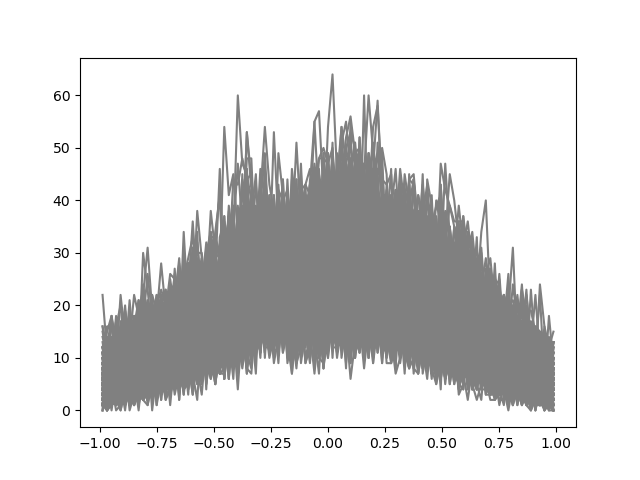

(101,)
(101,)
1764


In [36]:
plt.figure()
for i in np.arange(0,core.m_ens.shape[1]):
    y,binEdges=np.histogram(core.m_ens[:,[i]]*10**-6, bins=101, density = False, range = (-1,1))
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters,y,'-',color="gray")
    if np.max(y) > 650:
        y_save_large = y
plt.show()

print(bincenters.shape)
print(y.shape)
print(sum(y))

<IPython.core.display.Javascript object>


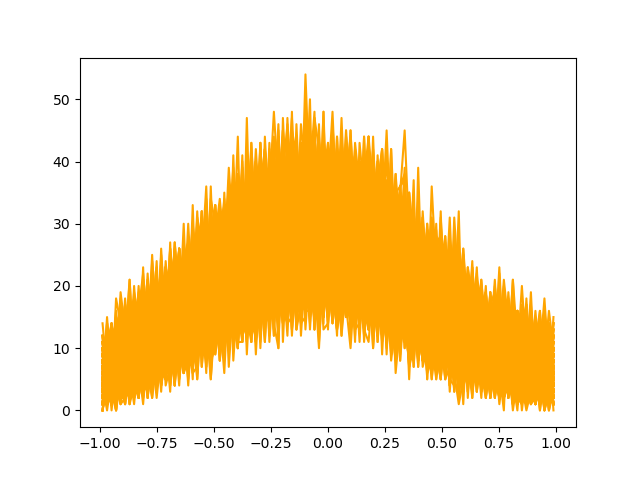

(101,)
(101,)
1748


In [37]:
plt.figure()
for i in np.arange(0,core.m_DSS.shape[1]):
    y,binEdges=np.histogram(core.m_DSS[:,[i]]*10**-6, bins=101, density = False, range = (-1,1))
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters,y,'-',color="orange") 
plt.show()

print(bincenters.shape)
print(y.shape)
print(sum(y))

<IPython.core.display.Javascript object>


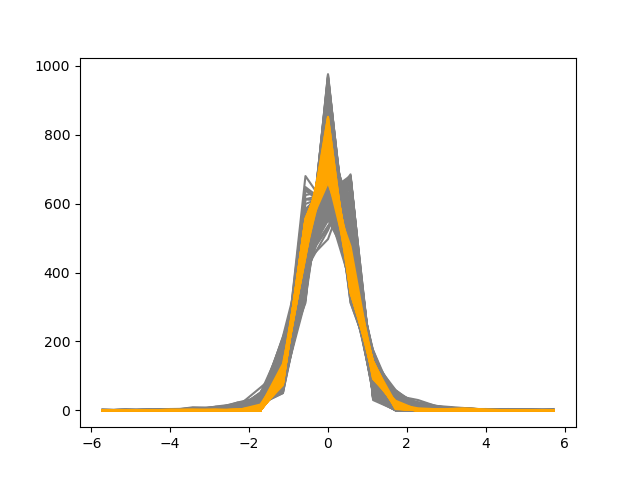

In [44]:
plt.figure()
for i in np.arange(0,core.m_ens.shape[1]):
    y,binEdges=np.histogram(core.m_ens[:,[i]]*10**-6, bins=21, density = False, range = (-6,6))
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters,y,'-',color="gray")
    
for i in np.arange(0,core.m_DSS.shape[1]):
    y,binEdges=np.histogram(core.m_DSS[:,[i]]*10**-6, bins=21, density = False, range = (-6,6))
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters,y,'-',color="orange")
    
plt.show()

<IPython.core.display.Javascript object>


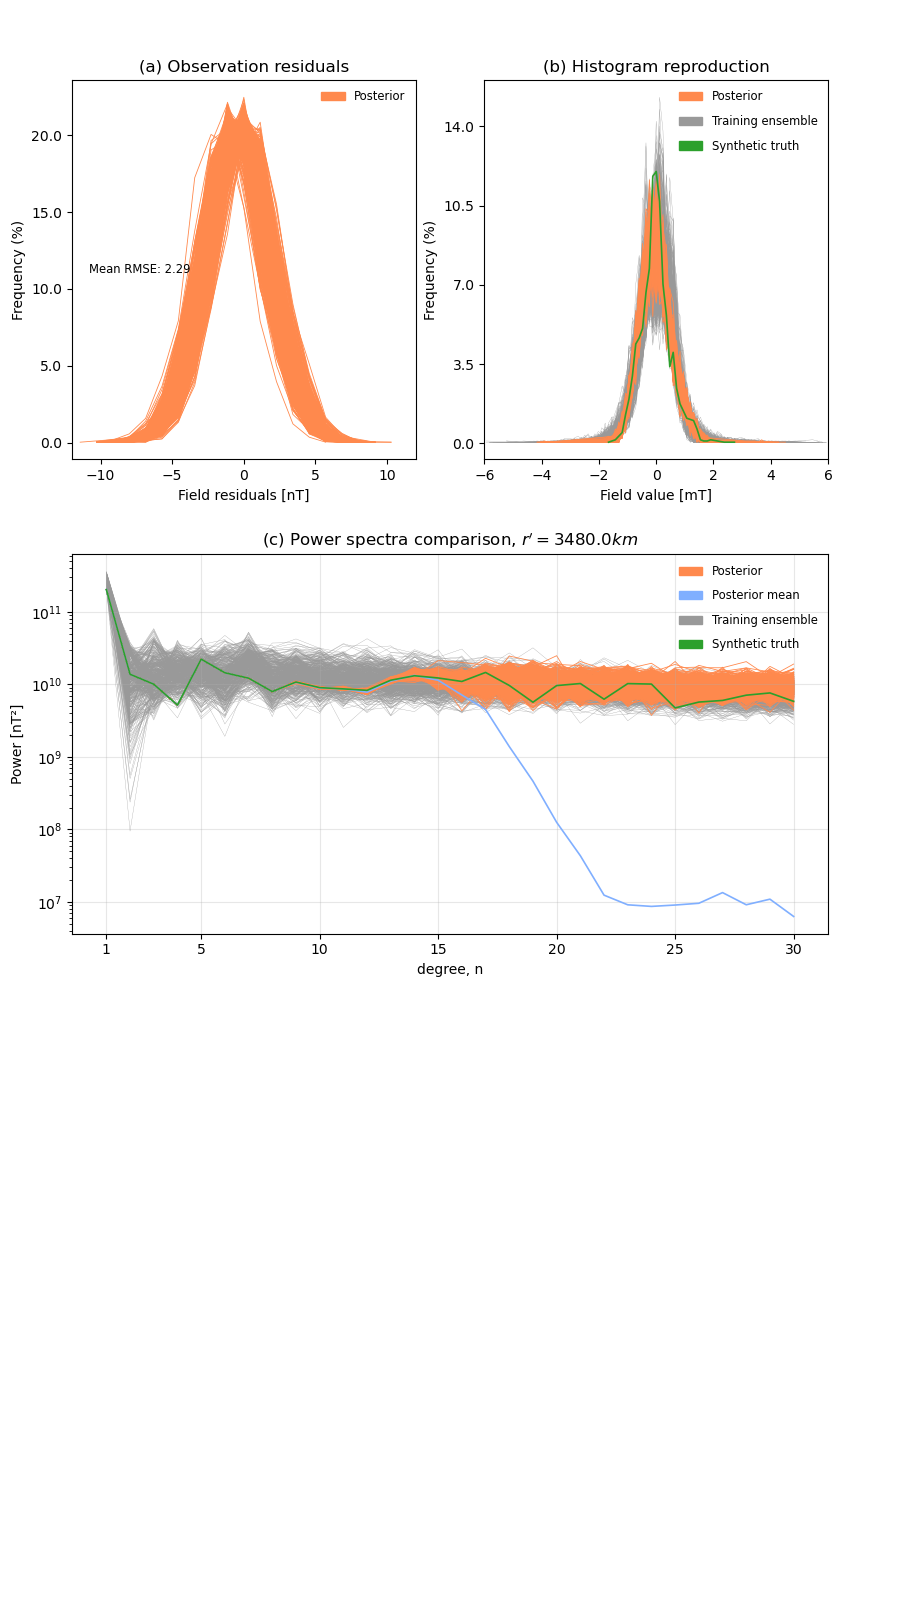

In [37]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

#truth_obj = s_source

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
#m_mode = m_DSS_mode
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = None, truth_obj = s_source,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              spec_ti_ens = True, lwidth = 0.6, lwidth_div = 3, lwidth_mult = 2,
                              label_fontsize = "small",
                              res_use = True, res_limit = [-12,12],sv_use = False, unit_field = "[mT]", 
                              hist_ti_ens_limit = [-6,6], hist_truth_res = False,
                              unit_transform_n_to_m = True, patch_legend = True, ens_prior = True,
                              model_dict = {}, figsize=(9,16), hist_ti_ens = "all", hist_density = False,
                              hist_bins = 101, res_bins = 21, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "case_core_synthetic_sht_fixrange3_perchist", 
                              save_dpi = 100, save_path = "images/")

In [6]:
m_DSS_shc.shape

(1891, 1000)

In [4]:
core.ensemble_B(core.g_spec, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
m_DSS_shc = core.B_ensemble[:,0,:].copy()

m_DSS_pred = core.G@core.m_DSS
m_DSS_res = s_sat.data.reshape(-1,1) - m_DSS_pred

m_DSS_pred = core.G@m_DSS_shc
m_DSS_res_shc = s_sat.data.reshape(-1,1) - m_DSS_pred

In [6]:
import matplotlib.patches as mpatches

color_rgb_zesty_pos = (1.0,  0.5372549019607843,  0.30196078431372547)
color_rgb_zesty_neg = (0.5019607843137255,  0.6862745098039216,  1.0)

leg_handle = [mpatches.Patch(color=color_rgb_zesty_pos, label='SDSSIM'), 
              mpatches.Patch(color=color_rgb_zesty_neg, label='SHC')]

plt.figure()
for i in np. arange(core.m_DSS.shape[1]):
    y,binEdges=np.histogram(m_DSS_res[:,i],bins=21)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    y_shc,binEdges=np.histogram(m_DSS_res_shc[:,i],bins=21)
    bincenters_shc = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters, y, '-', color = color_rgb_zesty_pos, label='SDSSIM', linewidth = 0.5,zorder=1)
    plt.plot(bincenters_shc, y_shc, '-', color = color_rgb_zesty_neg, label='SHC', linewidth = 0.5,zorder=0)
plt.legend(handles=leg_handle, numpoints=1, labelspacing=1, loc='best', fontsize="small", frameon=False)
plt.xlabel("Field residuals [nT]")
plt.ylabel("Count")
plt.title("Observation estimate residuals")
plt.show()

<IPython.core.display.Javascript object>

In [5]:
core.grid_glq(nmax = 400, r_at = core.r_cmb)
#core.grid_glq(nmax = 30, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()
#zs_eqa = core.m_DSS
#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()
#zs_mean_eqa = np.mean(core.m_DSS,axis=1)

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

In [6]:
import cmocean

<IPython.core.display.Javascript object>


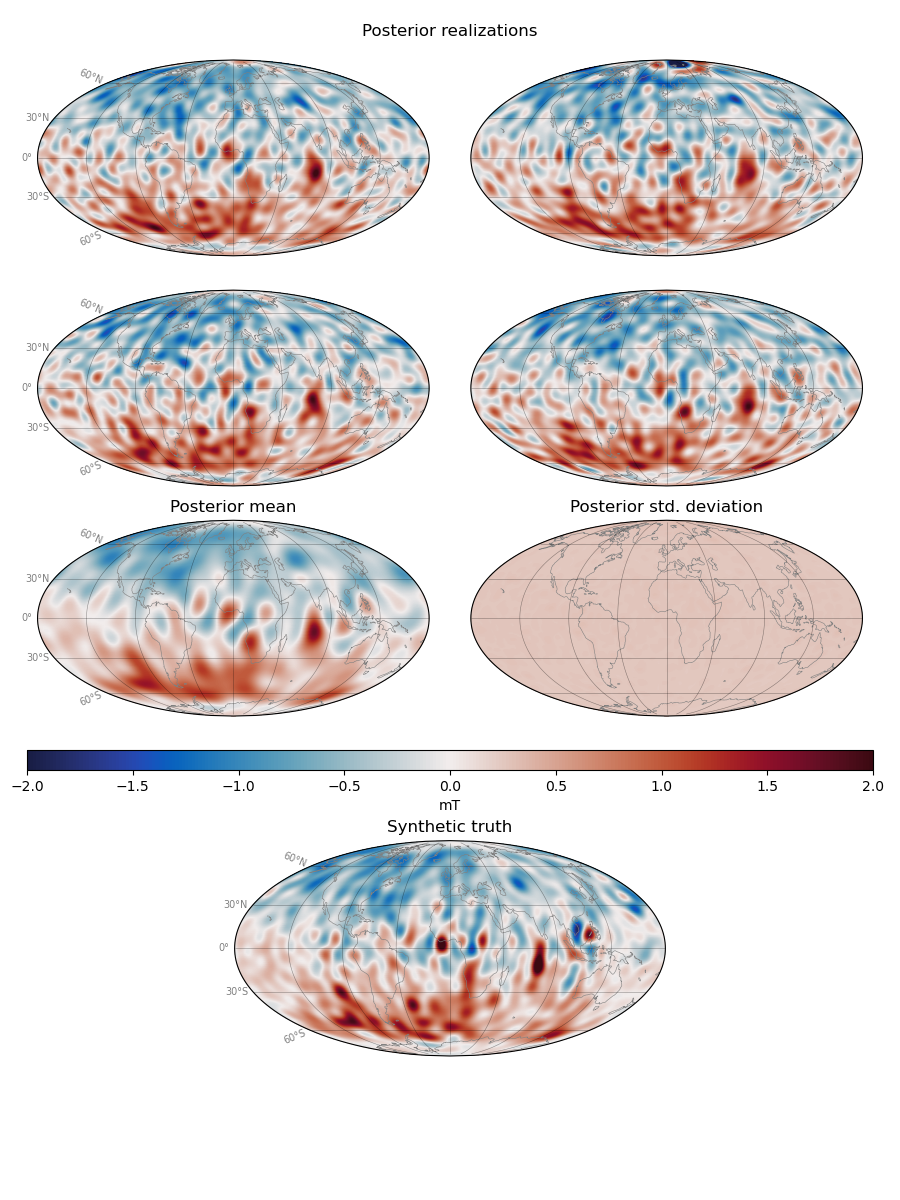

In [8]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 1, cbar_limit = [-2,2],
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "case_core_synthetic_sht", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100,
                        save_path = "images_thesis/", cmap=cmocean.cm.balance)


# Mode

In [14]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)

core.ensemble_B(core.g_spec_mean, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

core.ensemble_B(core.g_spec_mode, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
zs_mode_eqa = core.B_ensemble[:,0].copy()


<IPython.core.display.Javascript object>


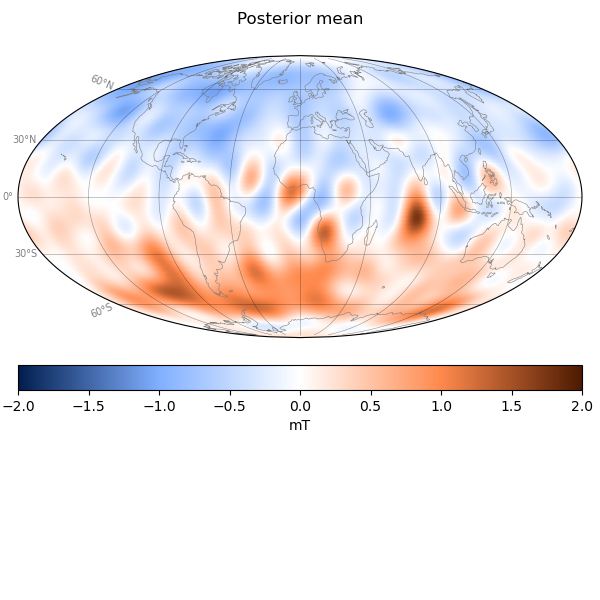

<IPython.core.display.Javascript object>


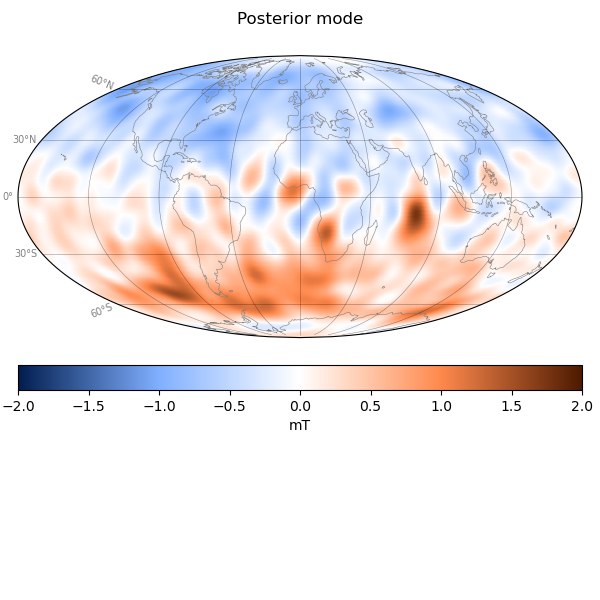

In [15]:
limit_data = [-2,2]

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_mean_eqa, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Posterior mean', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_mode_eqa, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Posterior mode', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

# New local dist

In [96]:
core.grid_glq(nmax = 30, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

In [97]:
zs_eqa.shape

(1891, 1000)

In [98]:
zs_sort = zs_eqa[np.argsort(np.mean(zs_eqa,axis=1)),:]

skip = 1
m_skip = zs_sort[:,:][0::skip]
m_skip_mean = np.mean(m_skip,axis=1)
m_skip_std = np.std(m_skip,axis=1)

In [99]:
m_skip.shape

(1891, 1000)

In [100]:
m_normal = np.random.normal(size=m_skip.shape) * m_skip_std[:,None] + m_skip_mean[:,None]

In [101]:
m_normal.shape

(1891, 1000)

In [102]:
N_bins = 21
m_centers = []
m_y = []
for i in np.arange(0,m_skip.shape[0]):
    y,binEdges=np.histogram(m_skip[i,:],bins=N_bins,density=False)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    m_centers.append(bincenters)
    m_y.append(y)
m_centers = np.array(m_centers)
m_y = np.array(m_y)

m_centers_n = []
m_y_n = []
for i in np.arange(0,m_skip.shape[0]):
    y,binEdges=np.histogram(m_normal[i,:],bins=N_bins,density=False)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    m_centers_n.append(bincenters)
    m_y_n.append(y)
m_centers_n = np.array(m_centers_n)
m_y_n = np.array(m_y_n)

In [103]:
from scipy import stats
kld = stats.entropy(m_y_n.T+10**(-30), m_y.T+10**(-30))

<IPython.core.display.Javascript object>


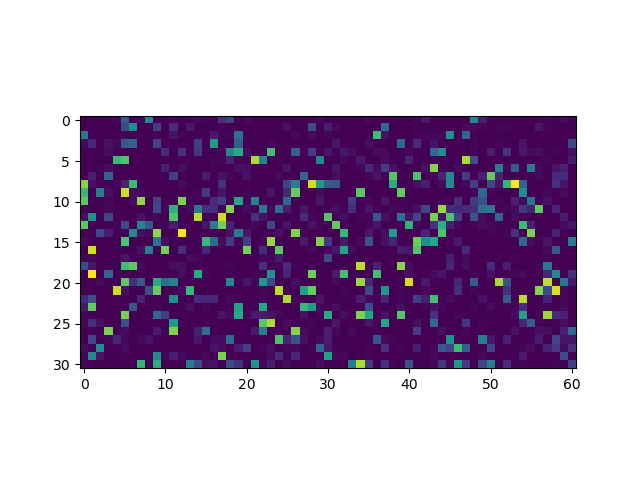

In [105]:
plt.figure()
plt.imshow(kld.reshape(31,61))
plt.show()

In [87]:
np.arange(0,20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

array([-1, -3, -5, -7, -9])

In [101]:


np.arange(0,20)[-np.arange(1,10,2)]

array([19, 17, 15, 13, 11])

<IPython.core.display.Javascript object>


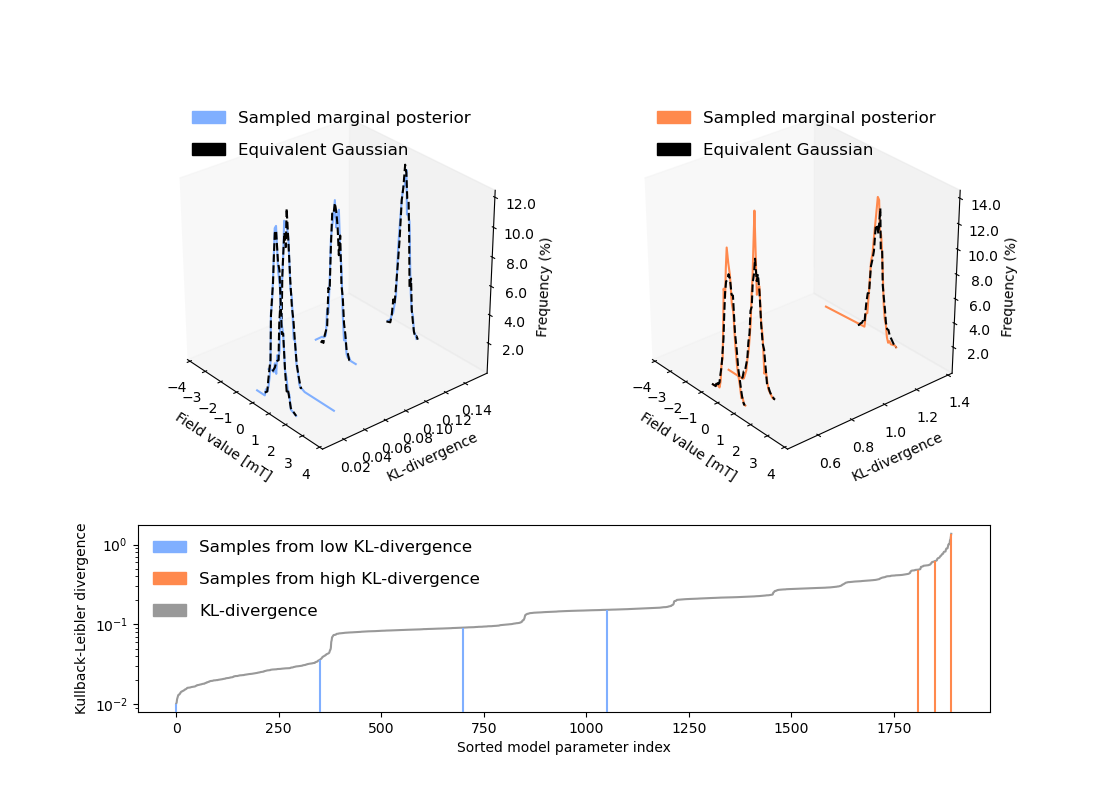

In [11]:
import importlib
importlib.reload(mt_util)
mt_util.plot_local_dist_KL(core.m_DSS, skip=1,random_seed = 250, leg_size = "large", save_dpi = 100, N_bins = 101,
                           xlim = [-4,4], hist_density = False, hist_range = [-4,4],
                           idx_high_start = -101, idx_high_interval = 40, 
                           idx_low_start = 0, idx_low_end = 1250, idx_low_interval = 350,
                           savefig = False, save_path = "images/", save_string = "case_core_synthetic_marg_fixrange_perchist") #230 is good, 450 is good

# Local distribution map

In [78]:
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

skip = 1
m_skip = core.m_DSS[:,:][0::skip]
lat_skip = core.lat[0::skip]
lon_skip = core.lon[0::skip]

N_bins = 51
m_centers = []
m_y = []
for i in np.arange(0,m_skip.shape[0]):
    y,binEdges=np.histogram(m_skip[i,:],bins=N_bins)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    
    m_centers.append(bincenters)
    m_y.append(y)
m_centers = np.array(m_centers)
m_y = np.array(m_y)

deg_range = 1
lat_skip_lin = np.linspace(lat_skip-deg_range,lat_skip+deg_range,N_bins)
lon_skip_lin = np.linspace(lon_skip-1*deg_range,lon_skip+1*deg_range,N_bins)

m_y_scaled = []
for i in np.arange(0,m_skip.shape[0]):
    scale = np.min(lat_skip_lin[:,i]) + (m_y[i,:]-np.min(m_y[i,:]))*(np.max(lat_skip_lin[:,i])-np.min(lat_skip_lin[:,i]))/(np.max(m_y[i,:])-np.min(m_y[i,:]))
    m_y_scaled.append(scale)
m_y_scaled = np.array(m_y_scaled)

local_lat = m_y_scaled.reshape(-1,)
local_lon = lon_skip_lin.T.reshape(-1,)
local_data = m_centers.reshape(-1,)

# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

point_size = 3
color_bg = (0.6,0.6,0.6)

<IPython.core.display.Javascript object>


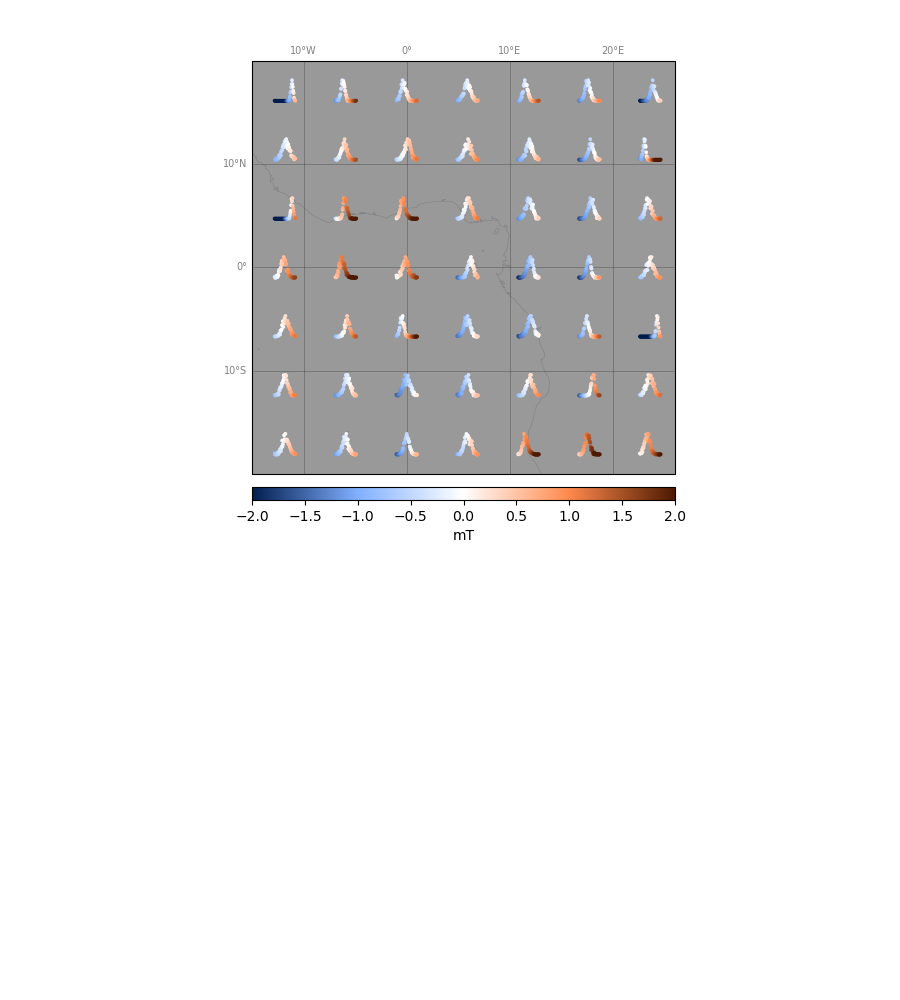

In [85]:
# West coast africa "cove"
mt_util.plot_global(lat = local_lat, lon = local_lon, data = local_data, limits_data = [-2, 2],
                cbar_h = 0.03, cbar_mm_factor = 1, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(9,10), coast_width = 0.4,
                bottom=0.5, top=0.95, hspace=0.01, left = 0.28, right = 0.75, extent = [-15, 26, -20, 20],
                title='', point_size=point_size, projection_transformation = "PlateCarree",
                savefig = False, save_dpi = 100, save_string = save_string_local + "_wafrica",
                save_path = "images/", use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4,
                data_on_top = True, color_bg = color_bg)

<IPython.core.display.Javascript object>


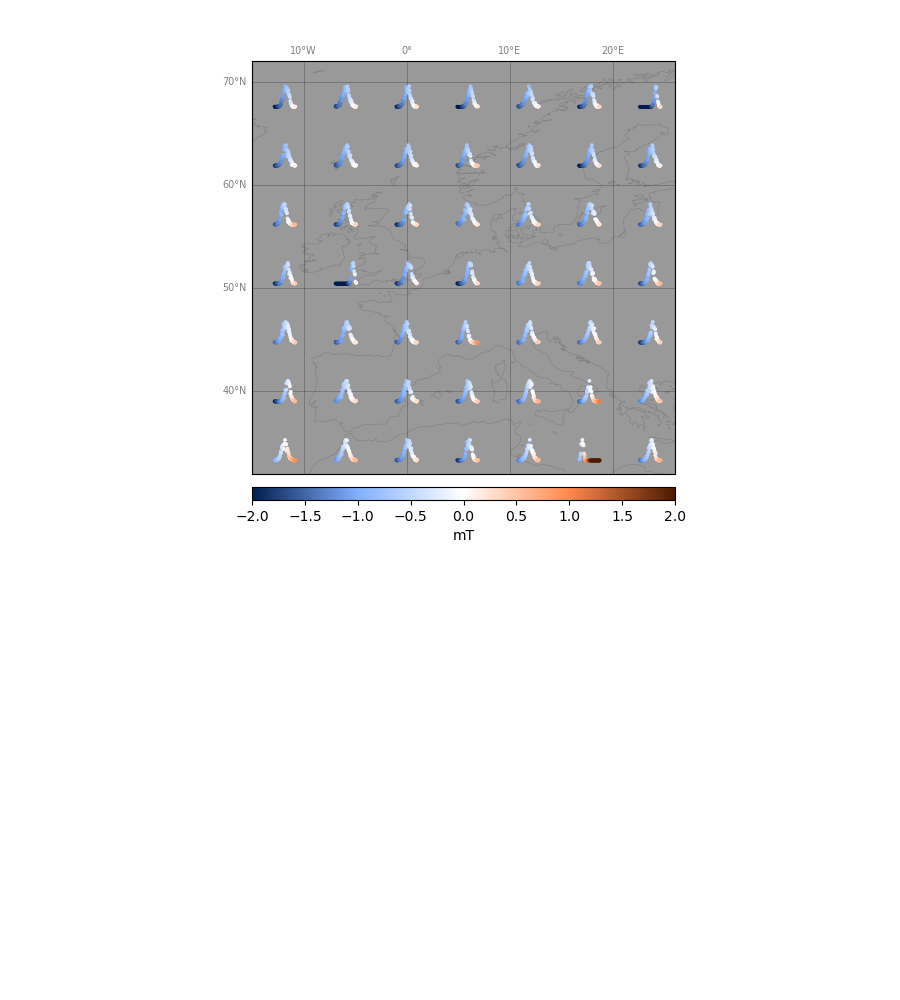

In [90]:
# EU
mt_util.plot_global(lat = local_lat, lon = local_lon, data = local_data, limits_data = [-2, 2],
                cbar_h = 0.03, cbar_mm_factor = 1, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(9,10), coast_width = 0.4,
                bottom=0.5, top=0.95, hspace=0.01, left = 0.28, right = 0.75, extent = [-15, 26, 32, 72],
                title='', point_size=point_size, projection_transformation = "PlateCarree",
                savefig = False, save_dpi = 100, save_string = save_string_local + "_europe",
                save_path = "images/", use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4,
                data_on_top = True, color_bg = color_bg)

<IPython.core.display.Javascript object>


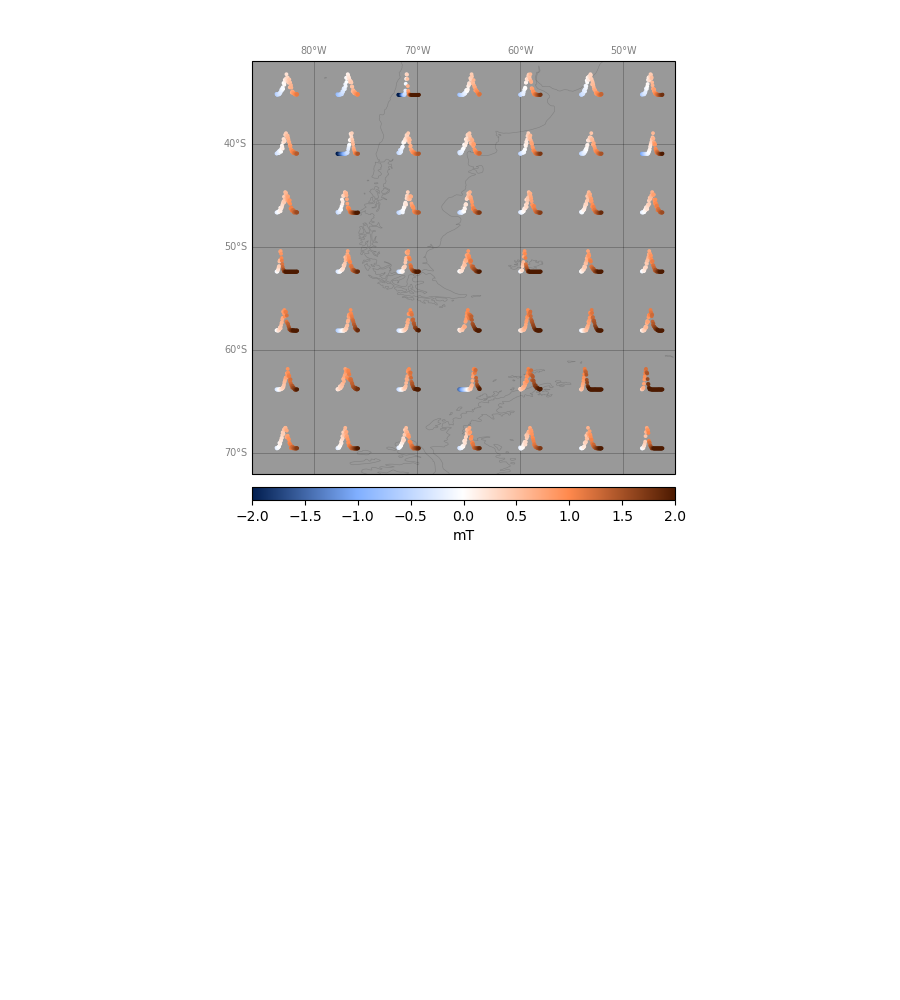

In [91]:
# South America tip
mt_util.plot_global(lat = local_lat, lon = local_lon, data = local_data, limits_data = [-2, 2],
                cbar_h = 0.03, cbar_mm_factor = 1, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(9,10), coast_width = 0.4,
                bottom=0.5, top=0.95, hspace=0.01, left = 0.28, right = 0.75, extent = [-45, -86, -32, -72],
                title='', point_size=point_size, projection_transformation = "PlateCarree",
                savefig = False, save_dpi = 100, save_string = save_string_local + "_samerica",
                save_path = "images/", use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4,
                data_on_top = True, color_bg = color_bg)

<IPython.core.display.Javascript object>


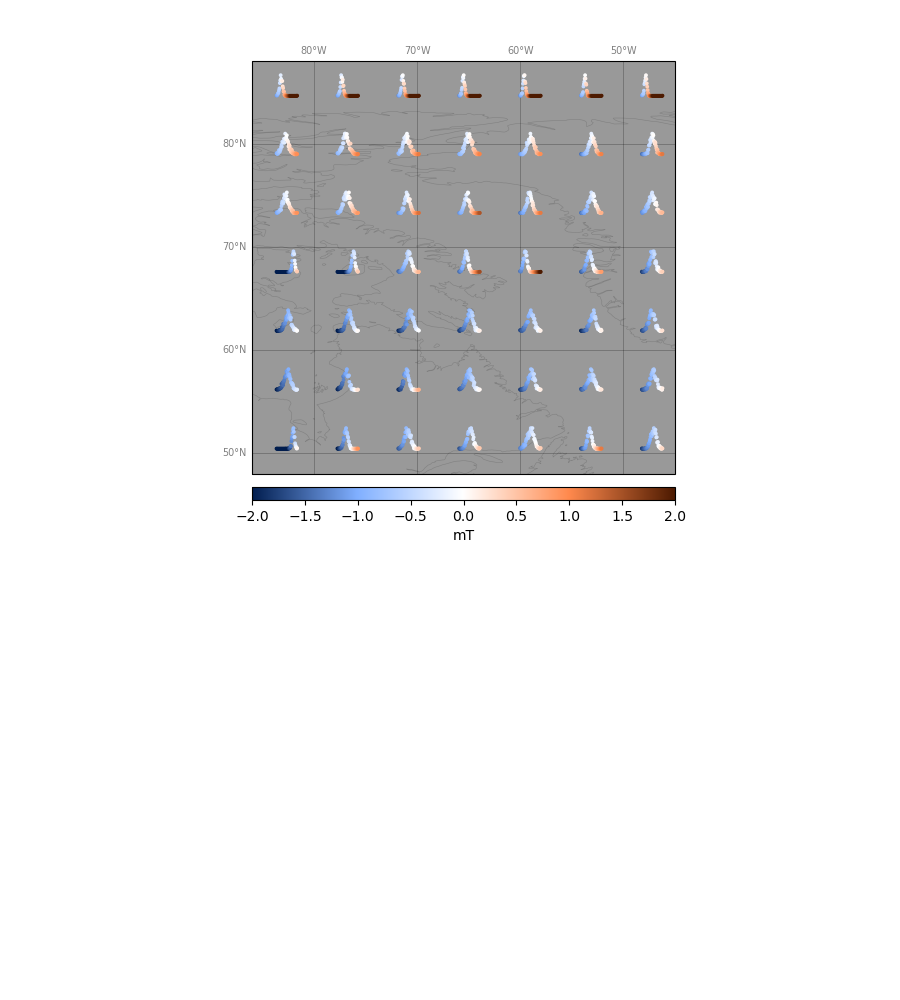

In [89]:
# West Greenland and East Canada
mt_util.plot_global(lat = local_lat, lon = local_lon, data = local_data, limits_data = [-2, 2],
                cbar_h = 0.03, cbar_mm_factor = 1, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(9,10), coast_width = 0.4,
                bottom=0.5, top=0.95, hspace=0.01, left = 0.28, right = 0.75, extent = [-45, -86, 48, 88],
                title='', point_size=point_size, projection_transformation = "PlateCarree",
                savefig = False, save_dpi = 100, save_string = save_string_local + "_wgreenland",
                save_path = "images/", use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4,
                data_on_top = True, color_bg = color_bg)

[915, 1225, 480, 215]


<IPython.core.display.Javascript object>


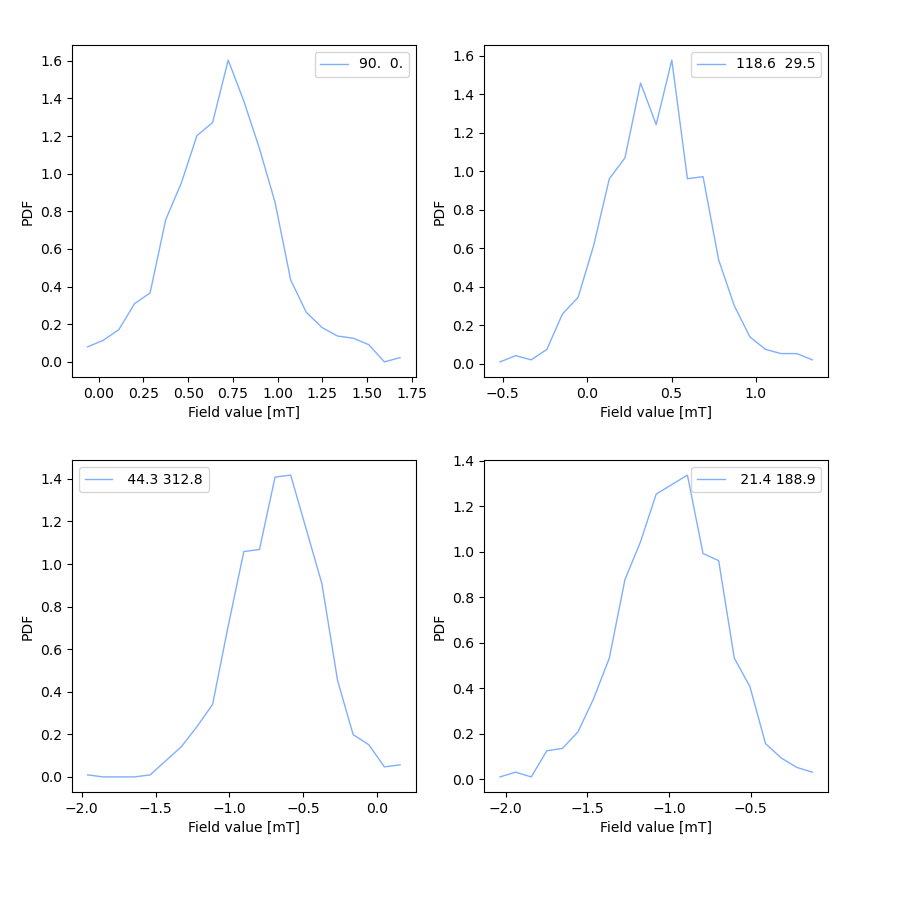

In [21]:
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

list_coord = np.array([[0,2], [-30,30], [45,-45], [70,-170]])
list_coord[:,0] = 90 - list_coord[:,0]
list_coord[:,1][list_coord[:,1]<0.0] = 360 + list_coord[:,1][list_coord[:,1]<0.0]

m_coord_sph = np.hstack((90 - core.lat.reshape(-1,1), core.lon.reshape(-1,1)))

idx_min = []
for coord in list_coord:
    idx_min.append(np.sum(np.abs(m_coord_sph - coord),axis=1).argmin())
    
print(idx_min)

m_hists_coord = m_coord_sph[idx_min]
m_hists = core.m_DSS[idx_min,:]


left=0.08
bottom=0.12
right=0.92
top=0.95
wspace = 0.2
hspace=0.25

color_rgb_zesty_pos = (1.0,  0.5372549019607843,  0.30196078431372547)
color_rgb_zesty_neg = (0.5019607843137255,  0.6862745098039216,  1.0)


m_hists_scale = m_hists*10**(-6)
tile_size_row = 2
tile_size_column = 2
label_fontsize = 10

fig = plt.figure(figsize=(9,9)) # Initiate figure with constrained layout
# Generate ratio lists
h_ratio = [1]*tile_size_row
w_ratio = [1]*tile_size_column
gs = fig.add_gridspec(tile_size_row, tile_size_column, height_ratios=h_ratio, width_ratios=w_ratio) # Add x-by-y grid

for i in np.arange(0,list_coord.shape[0]):

    ax = fig.add_subplot(gs[i])
    
    y,binEdges=np.histogram(m_hists_scale[i,:],bins=21,density=True)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])    
    ax.plot(bincenters, y, '-', color = color_rgb_zesty_neg, 
            label='{}'.format(str(np.round(m_hists_coord[i,:],decimals=1))).lstrip('[').rstrip(']'),
            linewidth = 1)

    #ax.set_title('test')
    #ax.annotate("test", (0.05, 0.5), xycoords='axes fraction', va='center', fontsize = label_fontsize)
    ax.set_xlabel("Field value [mT]")
    ax.set_ylabel("PDF")
    ax.legend(loc='best', fontsize = label_fontsize)
    

fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)